In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
import os
data_path = 'C:/Users/Elnour Tech/Downloads/lung-cancer'
print(os.listdir(data_path))

['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']


In [3]:
import os

def count_files_in_folders(path):
    # Dictionary to store the number of files in each folder
    folder_file_count = {}

    # Loop through each item in the specified path
    for root, dirs, files in os.walk(data_path):
        # Count the files in the current directory
        num_files = len(files)

        # Store the count in the dictionary with the folder name as the key
        folder_file_count[root] = num_files

    return folder_file_count

# Specify your path here
file_counts = count_files_in_folders(data_path)

# Print the results
for folder, count in file_counts.items():
    print(f"{folder}: {count} files")

C:/Users/Elnour Tech/Downloads/lung-cancer: 0 files
C:/Users/Elnour Tech/Downloads/lung-cancer\adenocarcinoma: 5000 files
C:/Users/Elnour Tech/Downloads/lung-cancer\benign: 5000 files
C:/Users/Elnour Tech/Downloads/lung-cancer\squamous_cell_carcinoma: 5000 files


In [4]:
image_dir = Path(data_path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.[jJ][pP][gG]')) + list(image_dir.glob(r'**/*.[pP][nN][gG]'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

[  972 14954  9648   637 10451  4928 11007  7425 10491    55  5798  2333
  6263 14756  2879  8776]


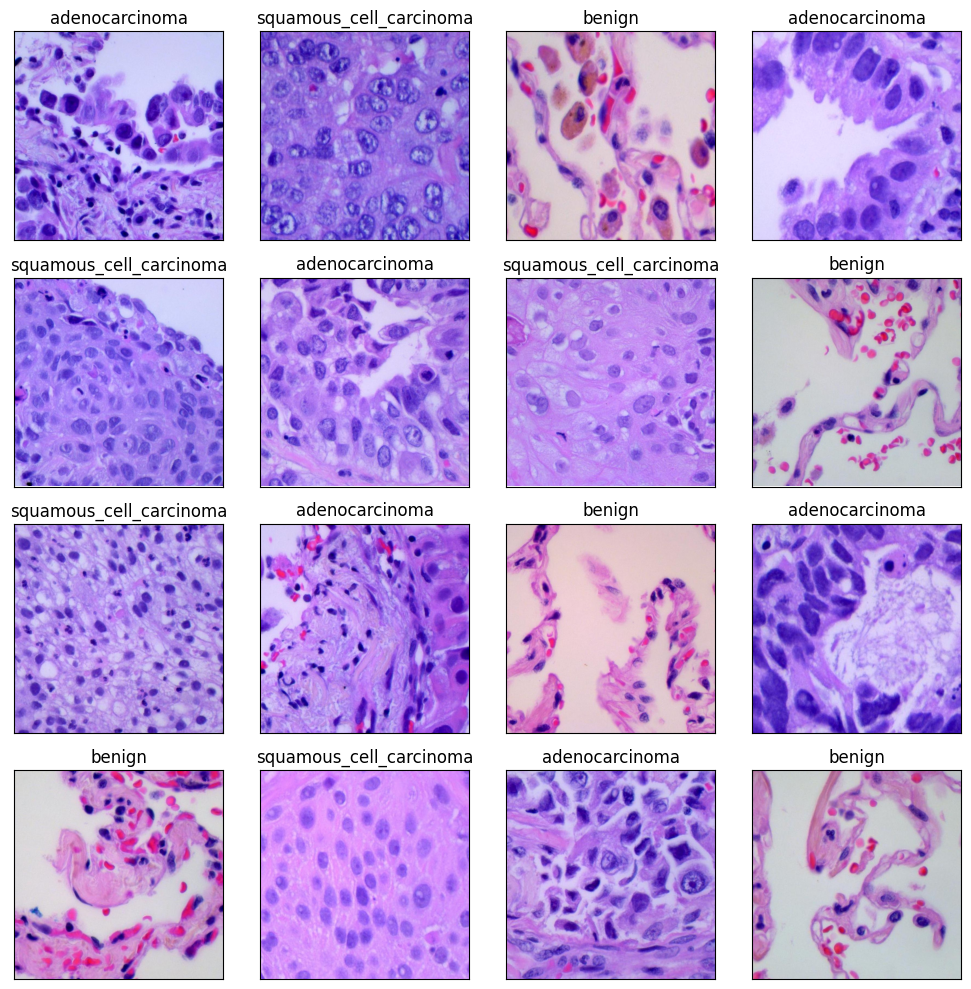

In [5]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df.shape

(12000, 2)

In [7]:
test_df.shape


(3000, 2)

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# Define the same rescaling for all sets (no augmentation)
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Still split into training and validation
)

## Training Set: 64%
train_images = data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

## Validation Set: 16%
val_images = data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

## Test Set: 20%
test_images = data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 9600 validated image filenames belonging to 3 classes.
Found 2400 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import models, layers

# Load the EfficientNetB4 base model
base_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top classification layer
    weights='imagenet'  # Use pre-trained weights
)

# Freeze the base model to prevent training its weights
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Use GAP instead of Flatten for better generalization
    layers.Dense(512, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(3, activation='softmax')  # Output layer (3 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,853,411 (87.18 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=3,         # Number of epochs with no improvement before stopping
    restore_best_weights=True # Restore model weights from the epoch with the best value
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitor validation loss
    factor=0.5,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement before reducing
    min_lr=1e-6           # Minimum learning rate
)

history = model.fit(
    train_images,             # Training data
    validation_data=val_images, # Validation data
    epochs=15,              # Maximum number of epochs
    callbacks=[early_stopping, reduce_lr] # Add callbacks here
)

C:\Users\Elnour Tech\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.7687 - loss: 0.6375 - val_accuracy: 0.9183 - val_loss: 0.1933 - learning_rate: 0.0010
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 293s 978ms/step - accuracy: 0.9020 - loss: 0.2491 - val_accuracy: 0.9171 - val_loss: 0.2043 - learning_rate: 0.0010
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9076 - loss: 0.2329 - val_accuracy: 0.9396 - val_loss: 0.1629 - learning_rate: 0.0010
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9053 - loss: 0.2252 - val_accuracy: 0.9333 - val_loss: 0.1635 - learning_rate: 0.0010
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.9155 - loss: 0.2077 - val_accuracy: 0.9329 - val_loss: 0.1588 - learning_rate: 0.0010
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.9165 - loss: 0.2074 - val_accuracy: 0.9404 - val_loss: 0.1513 - learning_rate: 0.0010
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.9234 - loss:

In [14]:
loss, accuracy = model.evaluate(val_images)
print(f"Validation Accuracy:{accuracy * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 861ms/step - accuracy: 0.9439 - loss: 0.1386
Validation Accuracy:94.71%


In [15]:
#Training set Accuracy
train_loss, train_acc = model.evaluate(train_images)
print(f"Training accuracy:{train_acc * 100:.2f}%")

300/300 ━━━━━━━━━━━━━━━━━━━━ 251s 837ms/step - accuracy: 0.9451 - loss: 0.1357
Training accuracy:94.45%


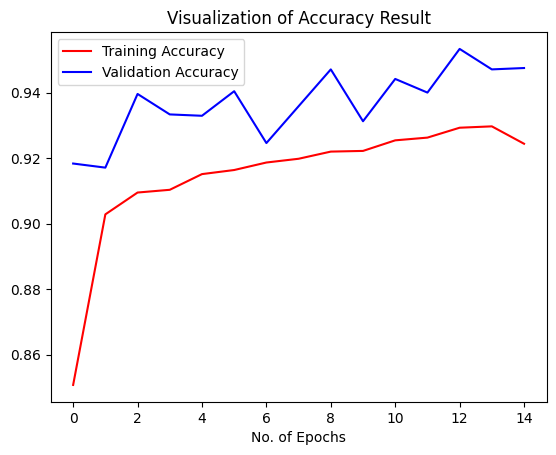

In [23]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy,color='red', label='Training Accuracy')
plt.plot(epochs, val_accuracy,color='blue', label='Validation Accuracy')
plt.title('Visualization of Accuracy Result')
plt.xlabel('No. of Epochs')
plt.legend();
plt.show()



In [19]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 586ms/step


In [20]:
# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['squamous_cell_carcinoma', 'benign', 'squamous_cell_carcinoma', 'adenocarcinoma', 'benign', 'benign', 'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma', 'squamous_cell_carcinoma']


In [21]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)

                         precision    recall  f1-score      support
adenocarcinoma            0.923729  0.945998  0.934731  1037.000000
benign                    0.992821  0.997938  0.995373   970.000000
squamous_cell_carcinoma   0.949117  0.920443  0.934560   993.000000
accuracy                  0.954333  0.954333  0.954333     0.954333
macro avg                 0.955222  0.954793  0.954888  3000.000000
weighted avg              0.954472  0.954333  0.954282  3000.000000


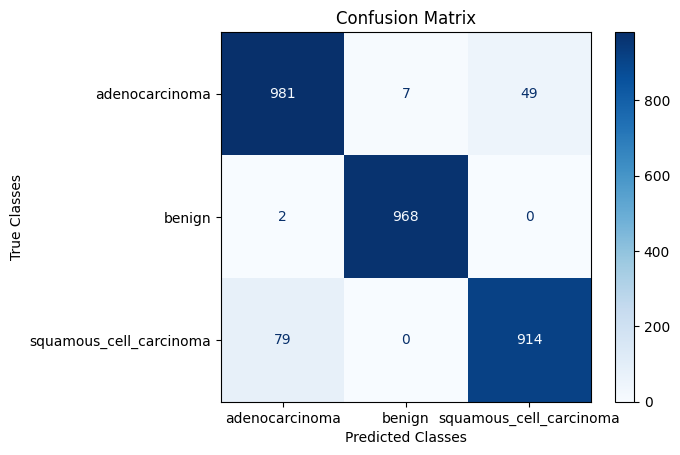

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and pred are defined
cm = confusion_matrix(y_test, pred)

# Define your class names
class_names = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']  # Replace with your actual class names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Change the color to blue
disp.plot(cmap='Blues')

plt.xlabel('Predicted Classes')  # Optional: add x-axis label
plt.ylabel('True Classes')        # Optional: add y-axis label
plt.title('Confusion Matrix')     # Optional: add title

plt.show()

In [24]:
model.save('InceptionV3.keras')